<a href="https://colab.research.google.com/github/Diego-Rodriguez16/AlgorithmsUN2024II/blob/main/Lab%20ATQ/dirodriguezd_LAB_ATQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Q18 Machine Learning Rolling Basis
## Presentado Por Diego Rodríguez
In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

<IPython.core.display.Javascript object>

In [ ]:
! pip install git+https://github.com/quantiacs/toolbox.git

  Cloning https://github.com/quantiacs/toolbox.git to /tmp/pip-req-build-n9qs_2x_
  Running command git clone --filter=blob:none --quiet https://github.com/quantiacs/toolbox.git /tmp/pip-req-build-n9qs_2x_
  Resolved https://github.com/quantiacs/toolbox.git to commit 568159460bcffea00317cd4a8ef57ad1b0eb4141
  Preparing metadata (setup.py) ... done


In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4151    0  4151    0     0   2058      0 --:--:--  0:00:02 --:--:--  2059
100  517k  100  517k    0     0   139k      0  0:00:03  0:00:03 --:--:--  547k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4119    0  4119    0     0   4497      0 --:--:-- --:--:-- --:--:--  4496
100  392k  100  392k    0     0   163k      0  0:00:02  0:00:02 --:--:--  665k


In [ ]:
import os

os.environ['API_KEY'] = 'f0d3c2f6-f4ed-4bcb-a1b6-444cc7b54f16'
os.environ['DATA_BASE_URL'] = 'https://data-api.quantiacs.io/'
os.environ['CACHE_RETENTION'] = '7'
os.environ['CACHE_DIR'] = 'data-cache'


In [ ]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

# Cambio el modelo lineal (Linear Regression) por Random Forest. Esto se debe a que Random Forest puede manejar relaciones no lineales y características interdependientes de manera más eficiente.
# Esto es ideal para datos financieros, donde las relaciones entre variables suelen ser complejas y no lineales.
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error


In [ ]:
# Cargar todos los activos del spx
""# Cargar todos los activos del SPX
"""
Carga los datos históricos de los últimos 5 años de los activos especificados.

Parámetros:
    tail (int): Número de días de datos históricos a cargar.
    assets (list): Lista de activos a cargar.

Retorna:
    DataFrame: Un DataFrame con los datos históricos de los activos especificados.
"""
stock_data = qndata.stocks.load_spx_data(tail=365 * 5, assets=[
    "NAS:AAPL",  # Apple Inc.: Líder en productos electrónicos y servicios digitales.
    "NAS:MSFT",  # Microsoft Corp.: Desarrollador de software y servicios en la nube.
    "NAS:GOOGL", # Alphabet Inc. (Google): Dominante en búsquedas y publicidad online.
    "NAS:NVDA",  # NVIDIA: Fabricante de GPUs y líder en inteligencia artificial.
    "NAS:META",  # Meta Platforms: Dueña de Facebook, Instagram, y en desarrollo del metaverso.
    "NAS:TSLA",  # Tesla Inc.: Innovador en vehículos eléctricos y energía renovable.
    "NAS:AMZN",  # Amazon: Gigante del comercio electrónico y servicios en la nube.
    "NAS:INTC",  # Intel Corp.: Líder en la fabricación de microprocesadores.
    "NAS:CSCO",  # Cisco Systems: Proveedor de equipos de redes y ciberseguridad.
    "NAS:PEP",   # PepsiCo Inc.: Multinacional de alimentos y bebidas.
    "NAS:ADBE",  # Adobe Inc.: Software para diseño y multimedia.
    "NAS:CMCSA", # Comcast: Proveedor de telecomunicaciones y servicios de medios.
    "NAS:AVGO",  # Broadcom: Fabricante de semiconductores para diversas industrias.
    "NAS:COST",  # Costco: Minorista de productos a granel a precios competitivos.
    "NAS:TXN",   # Texas Instruments: Productor de semiconductores y tecnología analógica.
    "NAS:QCOM",  # Qualcomm: Líder en semiconductores y tecnología móvil.
    "NAS:AMD",   # AMD: Competencia de Intel y NVIDIA en semiconductores y GPUs.
    "NAS:AMGN",  # Amgen: Empresa de biotecnología enfocada en terapias innovadoras.
    "NAS:INTU",  # Intuit: Software financiero, conocido por TurboTax y QuickBooks.
    "NAS:BKNG"   # Booking Holdings: Plataforma de reservas de viajes en línea.
])

# Filtrar solo los activos líquidos
is_liquid = stock_data.sel(field="is_liquid")
stock_data = stock_data.where(is_liquid)

# Asignar valores individuales de campos
open_ = stock_data.sel(field="open")
close = stock_data.sel(field="close")
high = stock_data.sel(field="high")
low = stock_data.sel(field="low")


fetched chunk 1/1 0s
Data loaded 0s


In [ ]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence (MACD);
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index (RSI);
       * the logarithm of the closing price.
    Nuevos Cambios:
       * On-Balance Volume (OBV): Relaciona el volumen de operaciones con el movimiento del precio.
       * Average True Range (ATR): Mide la volatilidad del precio, reflejando el nivel de riesgo.
       * Bollinger Bands Width: Captura la volatilidad mediante la diferencia entre las bandas superior e inferior.
       * Williams %R: Identifica niveles de sobrecompra o sobreventa.
    """

    # Trend indicator:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)
    trend = trend.expand_dims(field=["trend"])

    # Moving Average Convergence Divergence (MACD):
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)
    macd2_signal = macd2_signal.sel(field="close").expand_dims(field=["macd"])

    # Volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14).expand_dims(field=["volatility"])

    # Stochastic Oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)
    d = d.expand_dims(field=["stochastic_d"])

    # Relative Strength Index (RSI):
    rsi = qnta.rsi(data.sel(field="close")).expand_dims(field=["rsi"])

    # Logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0)  # Fill NaN values
    price = np.log(price).expand_dims(field=["price"])

    # On-Balance Volume (OBV):
    obv = qnta.obv(data.sel(field="close"), data.sel(field="vol")).expand_dims(field=["obv"])

    # Average True Range (ATR):
    atr = qnta.atr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14).expand_dims(field=["atr"])

    # Combine all features:
    result = xr.concat(
        [trend, macd2_signal, volatility, d, rsi, price, obv, atr],
        dim="field"
    )

    return result.transpose("time", "field", "asset")


In [ ]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NAS:AAPL,NAS:ADBE,NAS:AMD,NAS:AMGN,NAS:AMZN,NAS:AVGO,NAS:BKNG,NAS:CMCSA,NAS:COST,NAS:CSCO,NAS:GOOGL,NAS:INTC,NAS:INTU,NAS:META,NAS:MSFT,NAS:NVDA,NAS:PEP,NAS:QCOM,NAS:TSLA,NAS:TXN
time,,,,,,,,,,,,,,,,,,,,
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,-0.011361,-0.567533,-0.565913,-0.330251,0.148505,0.558600,-0.106338,-0.395746,0.011816,0.048021,0.249237,-0.476383,-0.093820,0.145847,-0.062986,-0.091217,-0.393102,-0.115118,0.471529,-0.143020
2025-01-13,-0.045787,-0.541151,-0.516815,-0.224579,0.133135,0.560032,-0.095362,-0.382315,-0.033290,0.044948,0.222222,-0.460135,-0.146361,0.101990,-0.076418,-0.153545,-0.344002,-0.104942,0.517715,-0.122234
2025-01-14,-0.061104,-0.503530,-0.533888,-0.250945,0.114669,0.534176,-0.090678,-0.381785,-0.060912,0.072444,0.190155,-0.453428,-0.092297,0.022690,-0.087875,-0.189081,-0.324727,-0.049793,0.429627,-0.079356


In [ ]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up more than 0.1%
    class_neutral = 0 # prices goes up or down las that 0.1%
    class_negative = -1 #price goes down more than 0.1%

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [ ]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NAS:AAPL,NAS:ADBE,NAS:AMD,NAS:AMGN,NAS:AMZN,NAS:AVGO,NAS:BKNG,NAS:CMCSA,NAS:COST,NAS:CSCO,NAS:GOOGL,NAS:INTC,NAS:INTU,NAS:META,NAS:MSFT,NAS:NVDA,NAS:PEP,NAS:QCOM,NAS:TSLA,NAS:TXN
time,,,,,,,,,,,,,,,,,,,,
2020-01-23,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1
2020-01-24,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2020-01-27,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2020-01-28,1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,-1,1,-1
2020-01-29,-1,1,1,-1,1,-1,-1,1,-1,1,-1,1,1,-1,1,1,1,-1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,-1,1,1,1,-1,1,1,1,-1,1,-1,1,-1,-1,-1,-1,1,1,1,1
2025-01-13,-1,1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1
2025-01-14,1,1,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,-1,1,1,1


In [ ]:
def get_model():
    """This is a constructor for the ML model (Gradient Boosting Regressor),
       which is more robust for non-linear relationships compared to Bayesian Ridge.

       Rationale:
       Gradient Boosting is chosen because:
       1. It can handle non-linear relationships in data, which are common in financial time series.
       2. It is robust to overfitting when tuned properly and works well with a mix of features.
       3. It uses an ensemble approach, combining weak learners (decision trees) to improve accuracy.
    """

    model = GradientBoostingRegressor(
        n_estimators=100,  # Number of boosting stages
        learning_rate=0.1,  # Shrinks the contribution of each tree
        max_depth=3,  # Depth of the individual regression estimators
        random_state=42  # Ensures reproducibility
    )
    return model


In [ ]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", how="any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", how="any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

{'NAS:AAPL': GradientBoostingRegressor(random_state=42), 'NAS:ADBE': GradientBoostingRegressor(random_state=42), 'NAS:AMD': GradientBoostingRegressor(random_state=42), 'NAS:AMGN': GradientBoostingRegressor(random_state=42), 'NAS:AMZN': GradientBoostingRegressor(random_state=42), 'NAS:AVGO': GradientBoostingRegressor(random_state=42), 'NAS:BKNG': GradientBoostingRegressor(random_state=42), 'NAS:CMCSA': GradientBoostingRegressor(random_state=42), 'NAS:COST': GradientBoostingRegressor(random_state=42), 'NAS:CSCO': GradientBoostingRegressor(random_state=42), 'NAS:GOOGL': GradientBoostingRegressor(random_state=42), 'NAS:INTC': GradientBoostingRegressor(random_state=42), 'NAS:INTU': GradientBoostingRegressor(random_state=42), 'NAS:META': GradientBoostingRegressor(random_state=42), 'NAS:MSFT': GradientBoostingRegressor(random_state=42), 'NAS:NVDA': GradientBoostingRegressor(random_state=42), 'NAS:PEP': GradientBoostingRegressor(random_state=42), 'NAS:QCOM': GradientBoostingRegressor(random_st

Feature: 0, Score: 0.11260
Feature: 1, Score: 0.11025
Feature: 2, Score: 0.08349
Feature: 3, Score: 0.10922
Feature: 4, Score: 0.14320
Feature: 5, Score: 0.13501
Feature: 6, Score: 0.14509
Feature: 7, Score: 0.16115


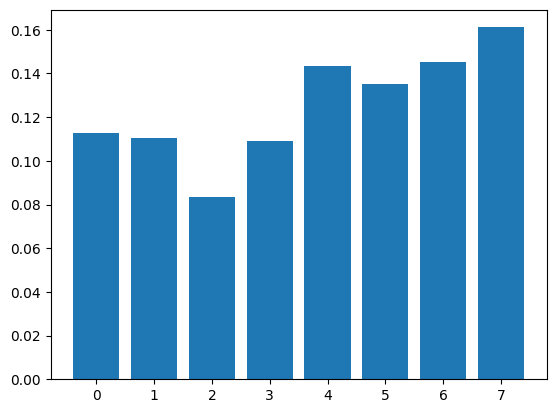

In [ ]:
# Showing which features are more important in predicting:

importance = models["NAS:AAPL"].feature_importances_ # Use feature_importances_ instead of coef_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [ ]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_s&p500' (time: 1254, asset: 20)> Size: 201kB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.2188893 ,  0.52591726, -0.15659711, ...,  0.14316891,
         0.13921861,  0.12185417],
       [-0.38626382,  0.15514488, -0.19597017, ..., -0.32026775,
        -0.4621758 , -0.2712738 ],
       [-0.3583367 , -0.20699111, -0.28327881, ..., -0.19924094,
        -0.47011376, -0.16878984]])
Coordinates:
  * asset    (asset) <U9 720B 'NAS:AAPL' 'NAS:ADBE' ... 'NAS:TSLA' 'NAS:TXN'
  * time     (time) datetime64[ns] 10kB 2020-01-23 2020-01-24 ... 2025-01-16
    field    <U5 20B 'close'


In [ ]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

47.417659278478176

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

In [ ]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-10,24487.702124,0.010545,0.139447,0.000000,-0.033557,47.390843,6.608530,0.123224,20.0,1.029554,1.839870
2025-01-13,24859.234769,0.015172,0.139427,0.000000,-0.033557,47.474165,6.619183,-0.271297,20.0,1.029741,1.839775
2025-01-14,25154.844246,0.011891,0.139381,0.000000,-0.033557,47.530631,6.624884,0.683904,20.0,1.029547,1.839565
2025-01-15,25008.151919,-0.005832,0.139466,-0.005832,-0.033557,47.349184,6.603619,-0.552040,20.0,1.029846,1.839910
2025-01-16,25340.799087,0.013302,0.139430,0.000000,-0.033557,47.417659,6.611433,-0.930396,20.0,1.030192,1.839491


time,2025-01-16
field,
sharpe_ratio,47.417659


NOTICE: The environment variable ENGINE_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/referee/submission/forCorrelation'
NOTICE: The environment variable STATAN_CORRELATION_URL was not specified. The default value is 'https://quantiacs.io/statan/correlation'
NOTICE: The environment variable PARTICIPANT_ID was not specified. The default value is '0'



Ok. This strategy does not correlate with other strategies.


In [ ]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

0.2934254801935203

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.29345169425091827

In [ ]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.8101439176785448

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [ ]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", how="any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [ ]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", how="any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [ ]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |                 #                           | 2298686 Elapsed Time: 0:00:01


fetched chunk 1/1 6s
Data loaded 7s


| |        #                                     | 165949 Elapsed Time: 0:00:00


fetched chunk 1/1 5s
Data loaded 5s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Run First Iteration...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |                #                            | 2172498 Elapsed Time: 0:00:01


fetched chunk 1/1 6s
Data loaded 7s
---
Run all iterations...
Load data...


| |  #                                             | 9060 Elapsed Time: 0:00:00
| |                  #                          | 2760558 Elapsed Time: 0:00:01


fetched chunk 1/8 4s


| |                #                            | 2775612 Elapsed Time: 0:00:01


fetched chunk 2/8 7s


| |                #                            | 2585220 Elapsed Time: 0:00:01


fetched chunk 3/8 11s


| |                   #                         | 3057697 Elapsed Time: 0:00:01


fetched chunk 4/8 14s


| |                  #                          | 3178528 Elapsed Time: 0:00:01


fetched chunk 5/8 18s


| |                #                            | 3388072 Elapsed Time: 0:00:01


fetched chunk 6/8 21s


| |                   #                         | 3555004 Elapsed Time: 0:00:01


fetched chunk 7/8 25s


| |                 #                           | 3173274 Elapsed Time: 0:00:01


fetched chunk 8/8 29s
Data loaded 30s


| | #                                              | 9060 Elapsed Time: 0:00:00
| |                  #                          | 2796519 Elapsed Time: 0:00:01


fetched chunk 1/7 4s


| |                 #                           | 2924777 Elapsed Time: 0:00:01


fetched chunk 2/7 7s


| |                   #                         | 2876646 Elapsed Time: 0:00:01


fetched chunk 3/7 11s


| |                  #                          | 3057443 Elapsed Time: 0:00:01


fetched chunk 4/7 14s


| |                 #                           | 3346807 Elapsed Time: 0:00:01


fetched chunk 5/7 18s


| |                    #                        | 3494011 Elapsed Time: 0:00:02


fetched chunk 6/7 22s


| |                  #                          | 3203764 Elapsed Time: 0:00:01


fetched chunk 7/7 25s
Data loaded 27s
Backtest...


| | #                                              | 9060 Elapsed Time: 0:00:00
| |                  #                          | 2812764 Elapsed Time: 0:00:01


fetched chunk 1/7 4s


| |                 #                           | 2943279 Elapsed Time: 0:00:01


fetched chunk 2/7 7s


| |                  #                          | 2892775 Elapsed Time: 0:00:01


fetched chunk 3/7 11s


| |                                   #         | 3081258 Elapsed Time: 0:00:05


fetched chunk 4/7 18s


| |                #                            | 3376191 Elapsed Time: 0:00:01


fetched chunk 5/7 21s


| |                  #                          | 3523585 Elapsed Time: 0:00:01


fetched chunk 6/7 25s


| |                   #                         | 3231228 Elapsed Time: 0:00:01


fetched chunk 7/7 29s
Data loaded 30s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.


NOTICE: The environment variable OUTPUT_PATH was not specified. The default value is 'fractions.nc.gz'


Write output: fractions.nc.gz


NOTICE: The environment variable OUT_STATE_PATH was not specified. The default value is 'state.out.pickle.gz'


State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-16
Sharpe Ratio = -1.4631521513290084


ERROR! The Sharpe Ratio is too low. -1.4631521513290084 < 0.7
Improve the strategy and make sure that the in-sample Sharpe Ratio more than 0.7.


---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5043 of 5043) |####################| Elapsed Time: 0:07:45 Time:  0:07:45


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!